# Прогнозирование оттока клиентов телеком компании

## СОДЕРЖАНИЕ
<a id="title"></a>

* [Загрузка библиотек](#import_libs)  
* [Данные](#data)
    * [Загрузка данных](#import_data)
    * [Первое впечатление](#first_impression)
    * [Первичный анализ данных](#first_analysis)
    * [Предварительные выводы](#first_conclusions)
* [План проекта](#plan)
    * [Описание проекта](#task_description)
    * [Описание данных](#data_description) 
* [Анализ данных](#data_analysis)
    * [Объединение выборок](#merge)
    * [Визуализация данных](#data_visual)
    * [Преобразование данных](#data_enginiring)
    * [Анализ на мультколениарность](#multicolleniar)
    * [Дисбаланс классов](#disballance)
    * [Выводы](#analis_concl)
* [Модели](#models)
    * [Разбиение на выборки](#split)
    * [Кодирование признаков](#features_encode)
    * [Обучение линейной модели](#fit_linear)
    * [Обучение CatBoost](#fit_catboost)
    * [Проверка на тестовой выборке](#test_check)
    * [Анализ важности признаков](#analisis_of_importance)
    * [Матрица ошибок](#error_matrix)
* [Выводы](#resume)

<a id="import_libs"></a>
## ЗАГРУЗКА БИБЛИОТЕК

In [1]:
# pip install phik

In [77]:
# импорт необходимых библиотек
import numpy as np
import scipy as sc
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from phik import phik_matrix
from phik.report import plot_correlation_matrix

import matplotlib.pyplot as plt
import seaborn as sns

<a id="data"></a>
## ДАННЫЕ

[go to the title](#title)
<a id="import_data"></a>
### Загрузка данных

In [3]:
# 
try:
    prsnl = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
    cntrt = pd.read_csv('/datasets/contract_new.csv')
    intnt = pd.read_csv('/datasets/internet_new.csv')
except:
    prsnl = pd.read_csv('personal_new.csv')
    phone = pd.read_csv('phone_new.csv')
    cntrt = pd.read_csv('contract_new.csv')
    intnt = pd.read_csv('internet_new.csv')

[go to the title](#title)
<a id="first_impression"></a>
### Первое впечатление

#### Personal

In [4]:
prsnl.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


#### Phone

In [5]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


#### Contract

In [6]:
cntrt.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


#### Internet

In [7]:
intnt.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Первичное знакомство с данными:
- 4 таблички с данными
- Большинство признаков категориальные
- Ключ во всех табличках customerID

[go to the title](#title)
<a id="first_analysis"></a>
### Первичный анализ данных

Ознакомимся с данными более подробно

#### Personal

In [8]:
prsnl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
# Естьли дубликаты в ID клиента?
prsnl['customerID'].duplicated().sum()

0

In [10]:
# распределение по половому признаку
prsnl['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [11]:
# Количество пенсионеров
prsnl['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [12]:
# Количество клиентов в браке
prsnl['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [13]:
# Количество клиентов с иждивенцами
prsnl['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

- В табличке нет повторяющихся пользователей
- Количество пользователей 7043
- Пропусков в категориальных признаках нет
- Признак пенсионного возраста выглядит как числовой, но на самом деле это категориальных признак. Надо переделать аналогично остальным признакам.
- Все признаки категориальные

#### Contract

In [14]:
# посмотрим на датасет с контрактами
cntrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [15]:
# Естьли дубликаты в ID клиента?
cntrt['customerID'].duplicated().sum()

0

In [16]:
# Количество действующих пользователей
(cntrt['EndDate'] == 'No').sum()

5942

In [17]:
# Уникальные значения в поле с типом оплаты
cntrt['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [18]:
# Уникальные значения с 
cntrt['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [19]:
# Уникальные зеначения в поле со способом оплаты
cntrt['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [20]:
# Проанализируем численные признаки
display(cntrt.describe())

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


- В табличке нет повторяющихся пользователей
- Количество действующих контрактов 5942 из 7043 (то есть закрытых - 1101)
- Пропусков в категориальных признаках нет
- Некорректный формат данных для поля с общей суммой за всё время. Необходимо перевести из обджект в числовой
- Количество контрактов совпадает с количеством пользователей (возможно что ID полностью совпадут в двух табличках, но это не точно)

#### Phone

In [21]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [22]:
# Есть ли дубликаты в ID клиента?
phone['customerID'].duplicated().sum()

0

In [23]:
# Уникальные зеначения 
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

- Дубликаты отсутствуют
- Количество строк меньше, чем в предыдущих табличках, значит при объедиениии датасетов необходимо будет заполнить получившиеся пустые значения в признаке MultipleLines

#### Internet

In [24]:
intnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
# 
clmn_list = list(intnt.columns)
clmn_list.remove('customerID')
for item in clmn_list:
    print(f'Уникальные значения для поля {item}:')
    print(intnt[item].value_counts(), end='\n\n')

Уникальные значения для поля InternetService:
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Уникальные значения для поля OnlineSecurity:
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

Уникальные значения для поля OnlineBackup:
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

Уникальные значения для поля DeviceProtection:
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

Уникальные значения для поля TechSupport:
No     3473
Yes    2044
Name: TechSupport, dtype: int64

Уникальные значения для поля StreamingTV:
No     2810
Yes    2707
Name: StreamingTV, dtype: int64

Уникальные значения для поля StreamingMovies:
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64



In [27]:
# Есть ли дубликаты в ID клиента?
intnt['customerID'].duplicated().sum()

0

- Дубликатов в ID нет
- Все признаки категориальные, однако строк сильно меньше, чем в таличках с пользователями и с контрактами. Необходимо будет заполнять пропуски при объединении датасетов

[go to the title](#title)
<a id="first_conclusions"></a>
### Предварительные выводы

- Были загружены 4 датасета с данными
- Количество пользоватлей и контрактов чуть более 7000
- Надеюсь, что большая часть ID совпадет в обеих табличках (выясним при объединении)
- Большая часть признаков категориальная. Однако при объединении всех 4 датасетов придется заполнять пропуски в некоторых признках, так как не все таблички одного размера.
- Необходимо будет изменить формат данных для столбца с суммарными затратами клиента по контракту. Сейчас они в формате object, а надо перевести в числовой.

[go to the title](#title)
<a id="plan"></a>
## ПЛАН ПРОЕКТА

<a id="task_description"></a>
### Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать
отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут
предложены промокоды и специальные условия. Команда оператора собрала
персональные данные о некоторых клиентах, информацию об их тарифах и
договорах.


<a id="data_description"></a>
### Описание данных

- Personal
    - `customerID` - ID клиента
    - `gender` - гендер
    - `SeniorCitizen` - наличие пенсионного статуса по возрасту
    - `Partner` - наличие супруга(и)
    - `Dependents` - наличие иждивенцев

- Contract
    - `customerID` - ID клиента
    - `BeginDate` - дата начала пользования услугами
    - `EndDate` - дата окончания позльзования услугами
    - `Type` - тип олаты (ежемсеячный, головой, итд)
    - `PaperlessBilling` - электронный платежный документ
    - `PaymentMethod` - способ оплаты
    - `MonthlyCharges` - ежемесячные траты на услуги
    - `TotalCharges` - всего потрачено денег на услуги

- Internet
    - `customerID` - ID клиента
    - `InternetService` - тип интернет соединения
    - `OnlineSecurity` - наличие услуги "блокировка небезопасных сайтов"
    - `OnlineBackup` - наличие облачного хранилища данных
    - `DeviceProtection` - наличие услуги "антивирус"
    - `TechSupport` - наличие выделенной линии техподдержки
    - `StreamingTV` - наличие ТВ
    - `StreamingMovies` - наличие стриминга фильмов
    
- Phone
    - `customerID` - ID клиента
    - `MultipleLines` - наличие возможности ведения параллельных линий во время звонка

[go to the title](#title)
<a id="data_analysis"></a>
## АНАЛИЗ ДАННЫХ

 В данном блоке будет более подробный анализ данных и подготовка признаков

[go to the title](#title)
<a id="merge"></a>
### Объединение выборок

In [28]:
# Объединим датассеты в один
# prsnl
# phone
# cntrt
# intnt
df = pd.merge(prsnl, cntrt, how='inner', on='customerID')

df = df.merge(phone, how='left', on='customerID')

df = df.merge(intnt, how='left', on='customerID')

print(df.shape)

(7043, 20)


In [29]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


### Преобразование данных

<a id="data_enginiring"></a>
[go to the title](#title)

In [30]:
# Чтобы категориальные признаки были едионнообразными преобразуем SeniorCitizen
df['SeniorCitizen'] = np.where(df['SeniorCitizen'] == 1, 'Yes', 'No')
df['SeniorCitizen'].value_counts()

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

#### Заполним пропуски

In [31]:
df['MultipleLines'] = df['MultipleLines'].fillna('unknown')
df['MultipleLines'].value_counts()

No         3390
Yes        2971
unknown     682
Name: MultipleLines, dtype: int64

In [32]:
df['InternetService'] = df['InternetService'].fillna('unknown')
df['OnlineSecurity'] = df['OnlineSecurity'].fillna('unknown')
df['OnlineBackup'] = df['OnlineBackup'].fillna('unknown')
df['DeviceProtection'] = df['DeviceProtection'].fillna('unknown')
df['TechSupport'] = df['TechSupport'].fillna('unknown')
df['StreamingTV'] = df['StreamingTV'].fillna('unknown')
df['StreamingMovies'] = df['StreamingMovies'].fillna('unknown')

#### Посмотрим что не так с TotalCharges

In [33]:
# Количество значений == ' '
(df['TotalCharges'] == ' ').sum()

11

In [34]:
# Удалим эти строки так как их очень мало
df = df[df['TotalCharges'] != ' ']

In [35]:
# Заменим тип данных на числовой
df['TotalCharges'] = df['TotalCharges'].astype('float64')

#### Сделаем новый признак, действующий контракт или нет

In [36]:
# если нет даты закрытия, считаем контракт действующим
df['isActive'] = np.where(df['EndDate']=='No', 1, 0)
df['isActive'].value_counts()

1    5931
0    1101
Name: isActive, dtype: int64

#### Переведем дату в дату

In [37]:
df['EndDate'] = df['EndDate'].replace({'No':'2020-02-01'})
df['EndDate'] = df['EndDate'].astype('datetime64')
df['BeginDate'] = df['BeginDate'].astype('datetime64')
df['ContractTime'] = (df['EndDate'] - df['BeginDate']).astype('timedelta64[D]')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   object        
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  MultipleLines     7032 non-null   object        
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

<a id="data_visual"></a>
[go to the title](#title)

### Визуализация данных

#### Визуализируем соотношение классов в категориальных признках

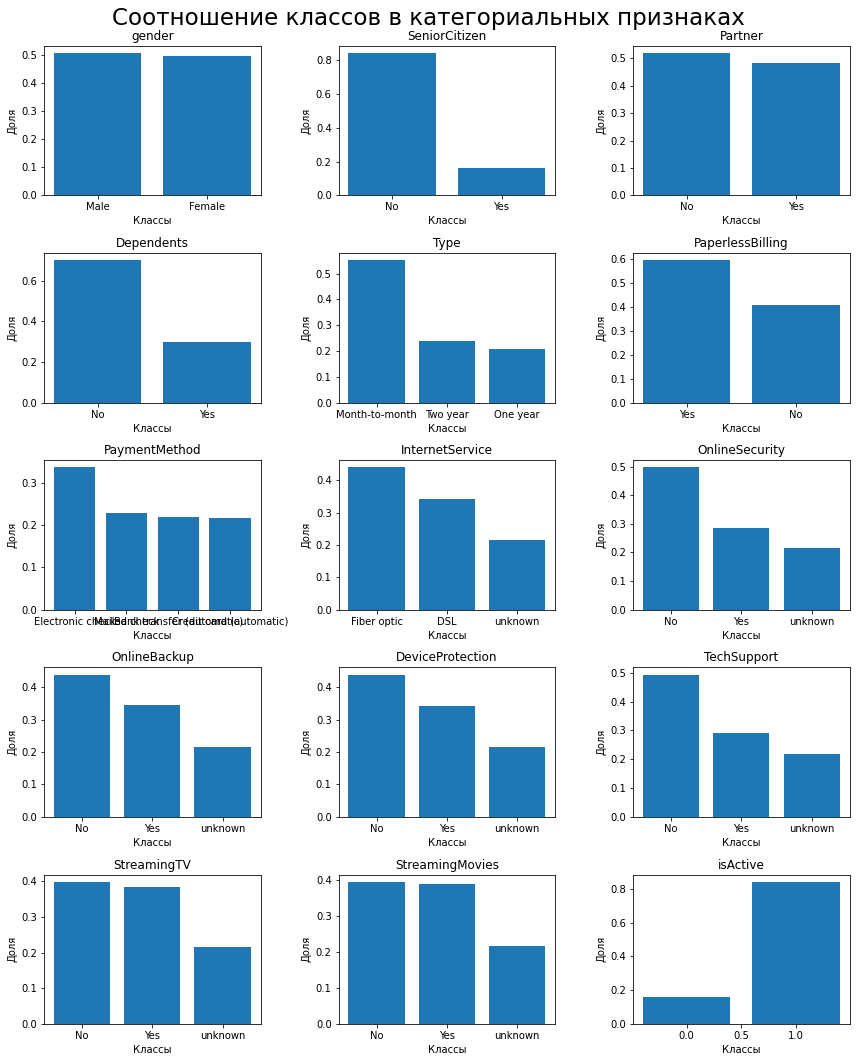

In [39]:
# посмотрим на соотношение все категориальных признаков
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
columns = ['gender', 'SeniorCitizen', 'Partner', 
           'Dependents', 'Type', 'PaperlessBilling', 
           'PaymentMethod', 'InternetService', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 
           'StreamingTV', 'StreamingMovies', 'isActive']

for i, ax in enumerate(axes.flat):
    column = columns[i]
    class_frequency = df[column].value_counts(normalize=True)
    ax.bar(class_frequency.index, class_frequency.values)
    # добавление подписи оси x
    ax.set_xlabel('Классы')
    # добавление подписи оси y
    ax.set_ylabel('Доля')
    ax.set_title(column)

# Зададим общий заголовок
fig.suptitle('Соотношение классов в категориальных признаках', fontsize=23)
plt.tight_layout()
plt.show()


#### Посмотрим на численные признаки

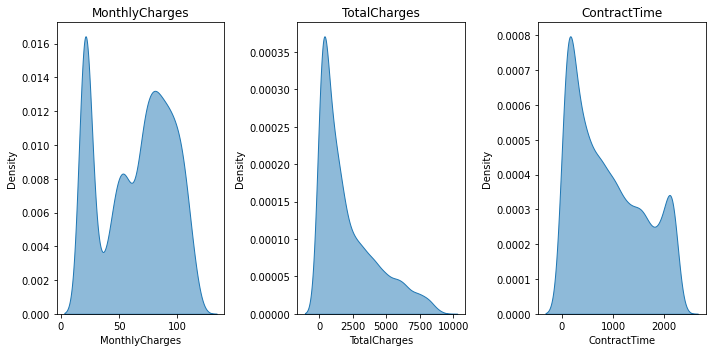

In [40]:
# 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.kdeplot(df['MonthlyCharges']
            , gridsize=500
            , bw_adjust=1
            , common_grid=True
            , fill=True
            , alpha=0.5
            , label='train'
            , ax=axes[0])

sns.kdeplot(df['TotalCharges']
            , gridsize=500
            , bw_adjust=1
            , common_grid=True
            , fill=True
            , alpha=0.5
            , label='train'
            , ax=axes[1])

sns.kdeplot(df['ContractTime']
            , gridsize=500
            , bw_adjust=1
            , common_grid=True
            , fill=True
            , alpha=0.5
            , label='train'
            , ax=axes[2])

# Настройка заголовков
axes[0].set_title('MonthlyCharges')
axes[1].set_title('TotalCharges')
axes[2].set_title('ContractTime')

# Показать графики
plt.tight_layout()
plt.show()


<a id="multicolleniar"></a>
[go to the title](#title)

### Анализ на мультколениарность

In [42]:
# 
matrix = phik_matrix(df.drop('customerID', axis=1), interval_cols = ['ContractTime', 'MonthlyCharges', 'TotalCharges'])
display(matrix)
# sns.heatmap(matrix, annot=False, cmap='coolwarm')

# # Настройка заголовка графика
# plt.title('Матрица Фи')

# # Отображение графика
# plt.show()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,isActive,ContractTime
gender,1.000000,0.000000,0.000000,0.000000,0.018540,0.018351,0.000000,0.000000,0.000000,0.005522,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008800,0.000000
SeniorCitizen,0.000000,1.000000,0.018075,0.323629,0.049516,0.090149,0.085800,0.241715,0.291989,0.304546,...,0.087978,0.160452,0.127108,0.109855,0.110029,0.135073,0.111610,0.113611,0.085708,0.065128
Partner,0.000000,0.018075,1.000000,0.651635,0.485513,0.178225,0.179294,0.010489,0.244661,0.204575,...,0.086495,0.000000,0.091140,0.091990,0.099685,0.076244,0.081850,0.077710,0.227597,0.450246
Dependents,0.000000,0.323629,0.651635,1.000000,0.201169,0.056795,0.146126,0.170650,0.222859,0.182283,...,0.011135,0.107328,0.116236,0.096785,0.093606,0.108747,0.087232,0.083895,0.048710,0.197317
BeginDate,0.018540,0.049516,0.485513,0.201169,1.000000,0.549761,0.765275,0.078664,0.467586,0.421848,...,0.468346,0.185601,0.459336,0.495096,0.501372,0.454019,0.418173,0.429770,0.461977,0.978241
EndDate,0.018351,0.090149,0.178225,0.056795,0.549761,1.000000,0.286678,0.062480,0.168837,0.172986,...,0.249694,0.116149,0.166274,0.236566,0.226005,0.150222,0.186040,0.198643,1.000000,0.399183
Type,0.000000,0.085800,0.179294,0.146126,0.765275,0.286678,1.000000,0.106151,0.277528,0.388557,...,0.244802,0.503776,0.636227,0.580887,0.630968,0.671126,0.548723,0.553780,0.094622,0.635623
PaperlessBilling,0.000000,0.241715,0.010489,0.170650,0.078664,0.062480,0.106151,1.000000,0.368945,0.467547,...,0.100063,0.231145,0.208084,0.195065,0.195398,0.200363,0.204617,0.202005,0.082789,0.018839
PaymentMethod,0.000000,0.291989,0.244661,0.222859,0.467586,0.168837,0.277528,0.368945,1.000000,0.398849,...,0.174953,0.323013,0.314888,0.292646,0.297187,0.316805,0.283902,0.284844,0.214300,0.348275
MonthlyCharges,0.005522,0.304546,0.204575,0.182283,0.421848,0.172986,0.388557,0.467547,0.398849,1.000000,...,0.710293,0.919005,0.812548,0.818861,0.827363,0.816645,0.864821,0.863544,0.225823,0.387649


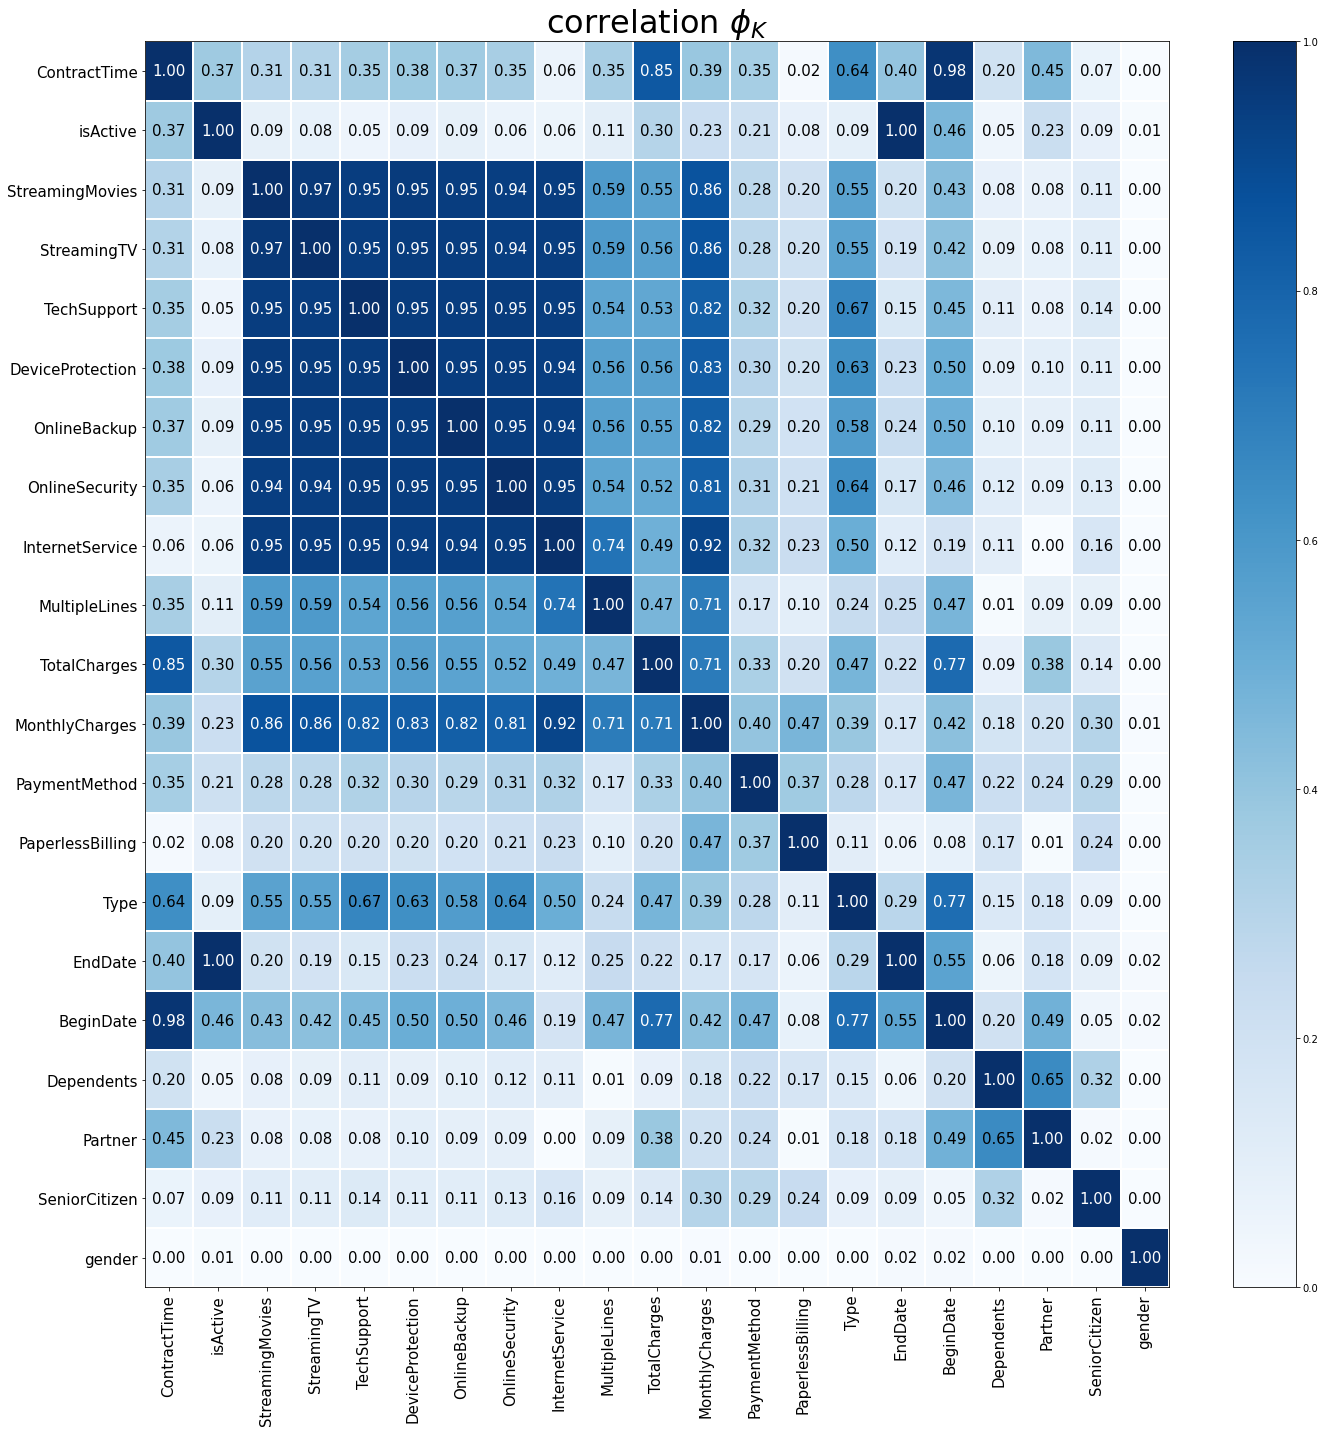

In [55]:
# Построим график:

plot_correlation_matrix(np.array(matrix)
                        , x_labels=matrix.columns
                        , y_labels=matrix.index
                        , vmin=0
                        , vmax=1
                        , color_map="Blues"
#                         , title=r"correlation $\phi_K$"
                        , fontsize_factor=1.5
                        , figsize=(20, 20))
plt.title(r"correlation $\phi_K$", size=32)
plt.tight_layout()

<a id="disballance"></a>
[go to the title](#title)

### Дисбаланс классов

In [43]:
# он есть
class_frequency = df['isActive'].value_counts(normalize=True)
print('Относительные размеры классов:', class_frequency, sep='\n')
print('Соотношение классов:', round(class_frequency[1] / class_frequency[0]))

Относительные размеры классов:
1    0.84343
0    0.15657
Name: isActive, dtype: float64
Соотношение классов: 5


<a id="analis_concl"></a>
[go to the title](#title)

### Выводы

Был проведен подробный анализ даннных:
- 4 исходных датасета были объеденины в один. Полностью совпали наборы ID в основных датасетах с клиентами и с контрактами. 
- Данных в табличке phone и internet было существенно меньше. Получившиеся пропущенные значения были заполнены значением `unknown`
- Ради единообразия признак `SeniorCitizen` был преобразован в текстовый формат
- В столбце с суммарными расходами по тарифу `TotalCharges` было обнаружено 11 строк с пробелом вместо суммы. Данные строки мешали преобразовать столбец из строкового типа в числовой, поэтому было принято решение их удалить. Так как их мало, должно быть не очень чувствительно для обучения модели.
- Был добавлен признак 'isActive' - действующий контрат или нет на основе даты закрытия контракта
- Также был добавлен признак продолжительности контракта в днях `ContractTime`
- Построены диаграммы для категориальных признаков и графики частотности для численных признаков
- Проведен анализ на мультиколлениарность: После заполения пустых значений в признаках из таблички `Internet` наблюдается высокая корреляция между всеми признаками. 
- Дисбаланс классов примерно 1 к 5 (отрицательный к положительному)

<a id="models"></a>
[go to the title](#title)

## МОДЕЛИ

In [56]:
RANDOM_STATE = 190623

<a id="split"></a>
[go to the title](#title)

### Разбиение на выборки

In [57]:
features = df.drop(['isActive', 'customerID', 'BeginDate', 'EndDate', 'TotalCharges'], axis=1)
target = df['isActive']

train_features, test_features, train_target, test_target = train_test_split(features
                                                                            , target
                                                                            , random_state=RANDOM_STATE
                                                                            , test_size=0.25)


print(train_features.shape)
print(train_target.shape)
print(test_features.shape)
print(test_target.shape)

(5274, 17)
(5274,)
(1758, 17)
(1758,)


<a id="features_encode"></a>
[go to the title](#title)

### Кодирование признаков

Отдельного кодирования тут не будет, так как кодирование либо происходит в пайплайне, либо отсутствует вовсе, так как модель этого не требует (CatBoost)

<a id="fit_linear"></a>
[go to the title](#title)

### Обучение линейной модели

In [59]:
numeric_columns = ['MonthlyCharges', 'ContractTime']

In [61]:
categ_columns = list(features.columns)
for column in numeric_columns:
    categ_columns.remove(column)

print('Numeric params:')
print(*numeric_columns)
print('\n')
print('Categorial params:')
print(*categ_columns)

Numeric params:
MonthlyCharges ContractTime


Categorial params:
gender SeniorCitizen Partner Dependents Type PaperlessBilling PaymentMethod MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies


In [71]:
%%time
column_trans = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_columns),
    ('categorial', OneHotEncoder(drop='first'), categ_columns)
])


# Создание пайплайна для последовательного выполнения препроцессора и модели
pipeline = Pipeline([
    ('column_trans', column_trans),
    ('logreg', LogisticRegression(random_state = RANDOM_STATE))
])

# Определение сетки параметров для GridSearchCV
param_grid = {
    'logreg__C': [0.1, 1, 10]
}

# Создание объекта GridSearchCV
gs_logreg = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=False)

# Обучаем модель на тренировочных данных
gs_logreg.fit(train_features, train_target)

# # Лучшие параметры модели
# best_params = gs_logreg.best_params_

# # Лучшая модель
# best_model = gs_logreg.best_estimator_


# Выводим наилучшие параметры и оценку метрики 
print("Best parameters: ", gs_logreg.best_params_)
print("Best AUC_ROC: ", gs_logreg.best_score_)

Best parameters:  {'logreg__C': 1}
Best AUC_ROC:  0.7676486378799001
CPU times: user 2.89 s, sys: 6.59 s, total: 9.48 s
Wall time: 9.46 s


<a id="fit_catboost"></a>
[go to the title](#title)

### Обучение CatBoost

In [76]:
%%time

pipeline = Pipeline([
    ('cat', CatBoostClassifier(verbose=False, random_state=RANDOM_STATE, cat_features=categ_columns))
])

# # Определяем сетку гиперпараметров для перебора
parameters = {
    'cat__learning_rate': [0.1, 0.01, 0.001],
#     'cat__depth': [4,6,8],
    'cat__n_estimators': [200, 300, 500],
    'cat__class_weights': [[1,5]],
    'cat__eval_metric': ['AUC']   
}

# # Создаем объект GridSearchCV с параметрами
gs_cat = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=False)

# # Обучаем модель на тренировочных данных
gs_cat.fit(train_features, train_target)

# # Выводим наилучшие параметры и оценку метрики f1
print("Best parameters: ", gs_cat.best_params_)
print("Best AUC_ROC: ", gs_cat.best_score_)

Best parameters:  {'cat__class_weights': [1, 5], 'cat__eval_metric': 'AUC', 'cat__learning_rate': 0.1, 'cat__n_estimators': 500}
Best AUC_ROC:  0.8732489586807007
CPU times: user 2min 7s, sys: 3.68 s, total: 2min 10s
Wall time: 2min 38s


<a id="test_check"></a>
[go to the title](#title)

### Проверка на тестовой выборке

In [78]:
# посчитаем метрику AUC_ROC на тестовой выборке для лучшей модели: 
best_model = gs_cat.best_estimator_
probabilities_valid = best_model.predict_proba(test_features)
probabilities_one_valid = probabilities_valid[:, 1]

# Вычисление метрики на тестовом наборе данных
print('Метрика ROC_AUC на тестовой выборке:', roc_auc_score(test_target, probabilities_one_valid)) 

Метрика ROC_AUC на тестовой выборке: 0.8679037332190201


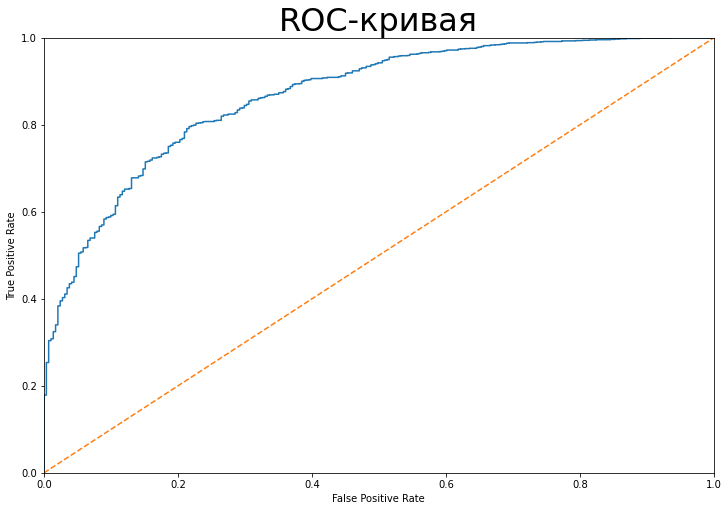

In [88]:
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_valid)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая', size=32)


plt.show()

In [89]:
#Код ревьюера
roc_auc_score(test_target, best_model.predict_proba(test_features)[:, 1])

0.8679037332190201

<a id="analisis_of_importance"></a>
[go to the title](#title)

### Анализ важности признаков

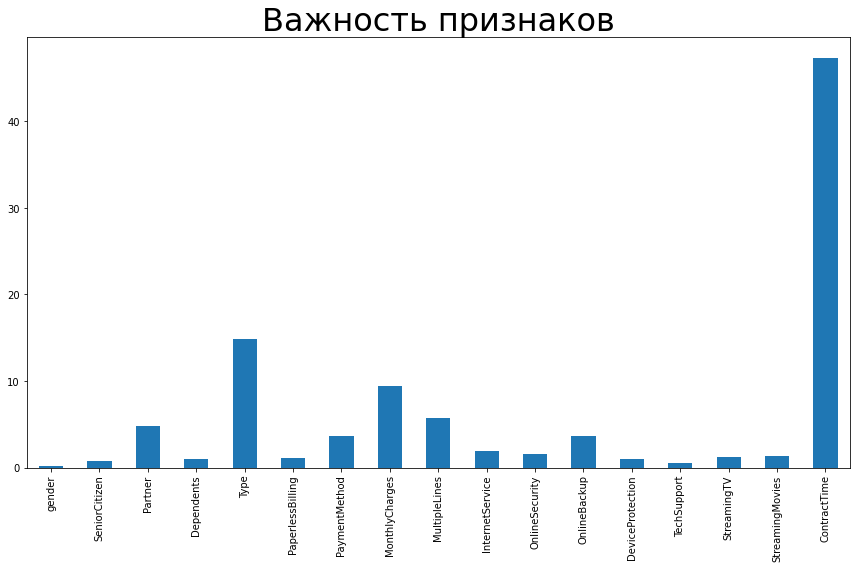

In [92]:
# отобразим на графике важность признаков:
important = pd.Series(best_model['cat'].feature_importances_,
                         features.columns)
fig, ax = plt.subplots(figsize=(12,8))
important.plot.bar(ax=ax)
ax.set_title("Важность признаков", size=32)
fig.tight_layout()

<a id="error_matrix"></a>
[go to the title](#title)

### Матрица ошибок

In [103]:
# Построим матрицу ошибок
matrix = confusion_matrix(test_target, best_model.predict(test_features))
print(matrix)

[[  43  248]
 [   5 1462]]


[go to the title](#title)
<a id="resume"></a>
### Выводы

- Исходный датасет был разделен на тестовую и обучающую выборки в соотношении 1:3
- Были обучены два типа моделей: Логистическая Регрессия и CatBoost используя пайплайн.
- Для регрессии исходный набор признаков преобразовывался. Численные признаки масштабировались, категориальные кодировались. Для CatBoost данных преобразований не делалось.
- Порезультатам кроссвалидации была отобрана лучшая модель CatBoost с параметрами:
    - `class_weights`: [1, 5]
    - `eval_metric`: 'AUC' 
    - `learning_rate`: 0.1
    - `n_estimators`: 500
    - `random_state`: 190623
- В результате на тестовой выборке удалось достич значения AUC-ROC = 0.867 (нормально)
- Была построена ROC-кривая и матрица ошибок
- Анализ важности признаков показал, что самый важный признак - это длительность контракта, на втором месте тип оплаты и на третьем - месячная плата.